In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
from textblob import TextBlob
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
df = pd.read_csv('tweets_final.csv')

In [3]:
df.head()

,_id,date,id,relevant,text,tweet,type,watson,annotation,urls,destination_url,valid_certificate
0,b'5b88752abb325e65390af240',2018-08-30 22:52:25+00:00,1035299228984041472,False,Best way to build empathy is through honesty a...,{'created_at': 'Thu Aug 30 22:52:25 +0000 2018...,vulnerability,"{'usage': {'text_units': 1, 'text_characters':...",irrelevant,[],NaN,NaN
1,b'5b8875d5bb325e65a22cf81b',2018-08-30 22:55:15+00:00,1035299941932036096,False,Cryptocurrency Scams Replacing Ransomware as A...,{'created_at': 'Thu Aug 30 22:55:15 +0000 2018...,ransomware,"{'usage': {'text_units': 1, 'text_characters':...",business,['https://ubm.io/2MCQwfg'],https://www.darkreading.com/endpoint-security,False
2,b'5b88768dbb325e65fa7e78e3',2018-08-30 22:58:20+00:00,1035300715470757889,False,Cryptocurrency Scams Replacing Ransomware as A...,{'created_at': 'Thu Aug 30 22:58:20 +0000 2018...,ransomware,"{'usage': {'text_units': 1, 'text_characters':...",business,['http://quantus.biz/security/2018/08/30/crypt...,http://www.quantusintel.group/,True
3,b'5b8876f9bb325e65fa7e78e4',2018-08-30 23:00:08+00:00,1035301167952211969,True,Protect your customers access Prestashop Ant...,{'created_at': 'Thu Aug 30 23:00:08 +0000 2018...,ddos,"{'usage': {'text_units': 1, 'text_characters':...",threat,['http://addons.prestashop.com/en/23513-anti-d...,https://addons.prestashop.com/en/23513-anti-dd...,True
4,b'5b8876f9bb325e65fa7e78e5',2018-08-30 23:00:09+00:00,1035301173178249217,True,Data leak from Huazhu Hotels may affect 130 mi...,{'created_at': 'Thu Aug 30 23:00:09 +0000 2018...,leak,"{'usage': {'text_units': 1, 'text_characters':...",threat,['http://www.hotelmanagement.net/tech/data-lea...,http://www.hotelmanagement.net/tech/data-leak-...,True


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21368 entries, 0 to 21367
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   _id                21368 non-null  object
 1   date               21368 non-null  object
 2   id                 21368 non-null  int64 
 3   relevant           21368 non-null  bool  
 4   text               21368 non-null  object
 5   tweet              21368 non-null  object
 6   type               21368 non-null  object
 7   watson             21368 non-null  object
 8   annotation         17536 non-null  object
 9   urls               21368 non-null  object
 10  destination_url    17010 non-null  object
 11  valid_certificate  17562 non-null  object
dtypes: bool(1), int64(1), object(10)
memory usage: 1.8+ MB


In [5]:
df.isnull().sum()

_id                     0
date                    0
id                      0
relevant                0
text                    0
tweet                   0
type                    0
watson                  0
annotation           3832
urls                    0
destination_url      4358
valid_certificate    3806
dtype: int64

In [6]:
df.columns

Index(['_id', 'date', 'id', 'relevant', 'text', 'tweet', 'type', 'watson',
       'annotation', 'urls', 'destination_url', 'valid_certificate'],
      dtype='object')

In [7]:
text_df = df.drop(['_id', 'date', 'id', 'relevant', 'tweet', 'type', 'watson',
       'annotation', 'urls', 'destination_url', 'valid_certificate'], axis=1)
text_df.head()

,text
0,Best way to build empathy is through honesty a...
1,Cryptocurrency Scams Replacing Ransomware as A...
2,Cryptocurrency Scams Replacing Ransomware as A...
3,Protect your customers access Prestashop Ant...
4,Data leak from Huazhu Hotels may affect 130 mi...


In [8]:
text_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21368 entries, 0 to 21367
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    21368 non-null  object
dtypes: object(1)
memory usage: 167.1+ KB


In [9]:
def data_processing(text):
    text = text.lower()
    text = re.sub(r"https\S+|www\S+https\S+", '',text, flags=re.MULTILINE)
    text = re.sub(r'\@w+|\#','',text)
    text = re.sub(r'[^\w\s]','',text)
    text_tokens = word_tokenize(text)
    filtered_text = [w for w in text_tokens if not w in stop_words]
    return " ".join(filtered_text)

In [10]:
text_df.text = text_df['text'].apply(data_processing)
text_df = text_df.drop_duplicates('text')

In [11]:
stemmer = PorterStemmer()
def stemming(data):
    text = [stemmer.stem(word) for word in data]
    return data

In [12]:
text_df['text'] = text_df['text'].apply(lambda x: stemming(x))
text_df.head()

,text
0,best way build empathy honesty vulnerability
1,cryptocurrency scams replacing ransomware atta...
3,protect customers access prestashop anti ddos ...
4,data leak huazhu hotels may affect 130 million...
5,instagram app 411788509910 denial service pack...


In [13]:
def polarity(text):
    return TextBlob(text).sentiment.polarity

In [14]:
text_df['polarity'] = text_df['text'].apply(polarity)
text_df.head(10)

,text,polarity
0,best way build empathy honesty vulnerability,1.00
1,cryptocurrency scams replacing ransomware atta...,0.00
3,protect customers access prestashop anti ddos ...,0.00
4,data leak huazhu hotels may affect 130 million...,0.00
5,instagram app 411788509910 denial service pack...,0.00
6,good slides advanced exploitation 64bit edge b...,0.55
7,cve20181000532 beep beep version 13 contains e...,0.00
8,upload yesterdays videos died latest ddos,0.50
9,well still protect ransomware offline apophiss...,0.00
10,cant get courage without walking vulnerability,0.00


In [15]:
def sentiment(label):
    if label <0:
        return "Negative"
    elif label ==0:
        return "Neutral"
    elif label>0:
        return "Positive"

In [16]:
text_df['sentiment'] = text_df['polarity'].apply(sentiment)
text_df.head()

,text,polarity,sentiment
0,best way build empathy honesty vulnerability,1.0,Positive
1,cryptocurrency scams replacing ransomware atta...,0.0,Neutral
3,protect customers access prestashop anti ddos ...,0.0,Neutral
4,data leak huazhu hotels may affect 130 million...,0.0,Neutral
5,instagram app 411788509910 denial service pack...,0.0,Neutral


<Axes: xlabel='sentiment', ylabel='count'>

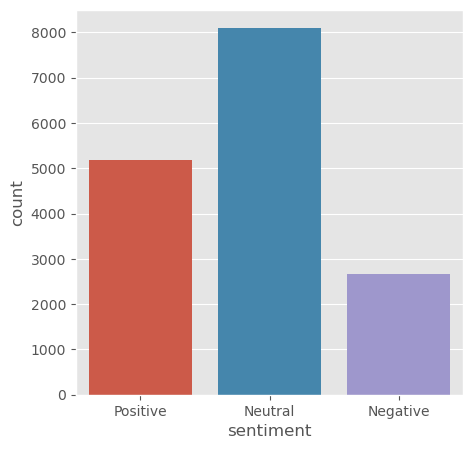

In [17]:
fig = plt.figure(figsize=(5,5))
sns.countplot(x='sentiment', data = text_df)

Text(0.5, 1.0, 'Distribution of sentiments')

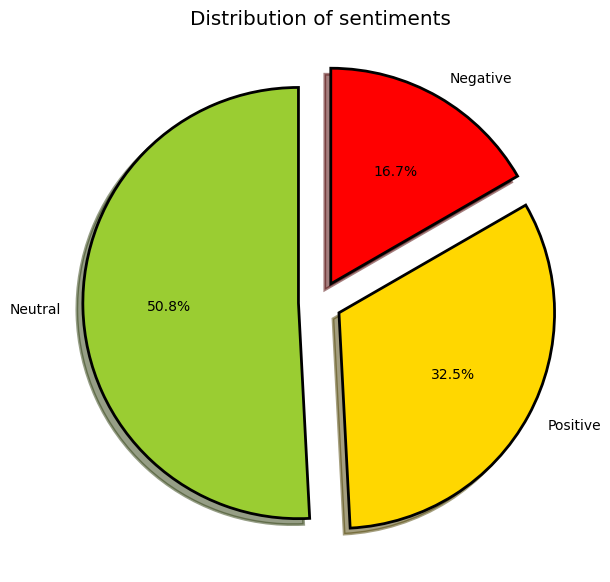

In [18]:
fig = plt.figure(figsize=(7,7))
colors = ("yellowgreen", "gold", "red")
wp = {'linewidth':2, 'edgecolor':"black"}
tags = text_df['sentiment'].value_counts()
explode = (0.1,0.1,0.1)
tags.plot(kind='pie', autopct='%1.1f%%', shadow=True, colors = colors,
         startangle=90, wedgeprops = wp, explode = explode, label='')
plt.title('Distribution of sentiments')

In [19]:
pos_tweets = text_df[text_df.sentiment == 'Positive']
pos_tweets = pos_tweets.sort_values(['polarity'], ascending= False)
pos_tweets.head()

,text,polarity,sentiment
0,best way build empathy honesty vulnerability,1.0,Positive
2223,internet vulnerability coin mining viruses hig...,1.0,Positive
14958,someone explain malwaretechblog jurors wiscons...,1.0,Positive
14807,brené brown see wonderful books courage vulner...,1.0,Positive
14799,vulnerability greatest measure courage brenebrown,1.0,Positive


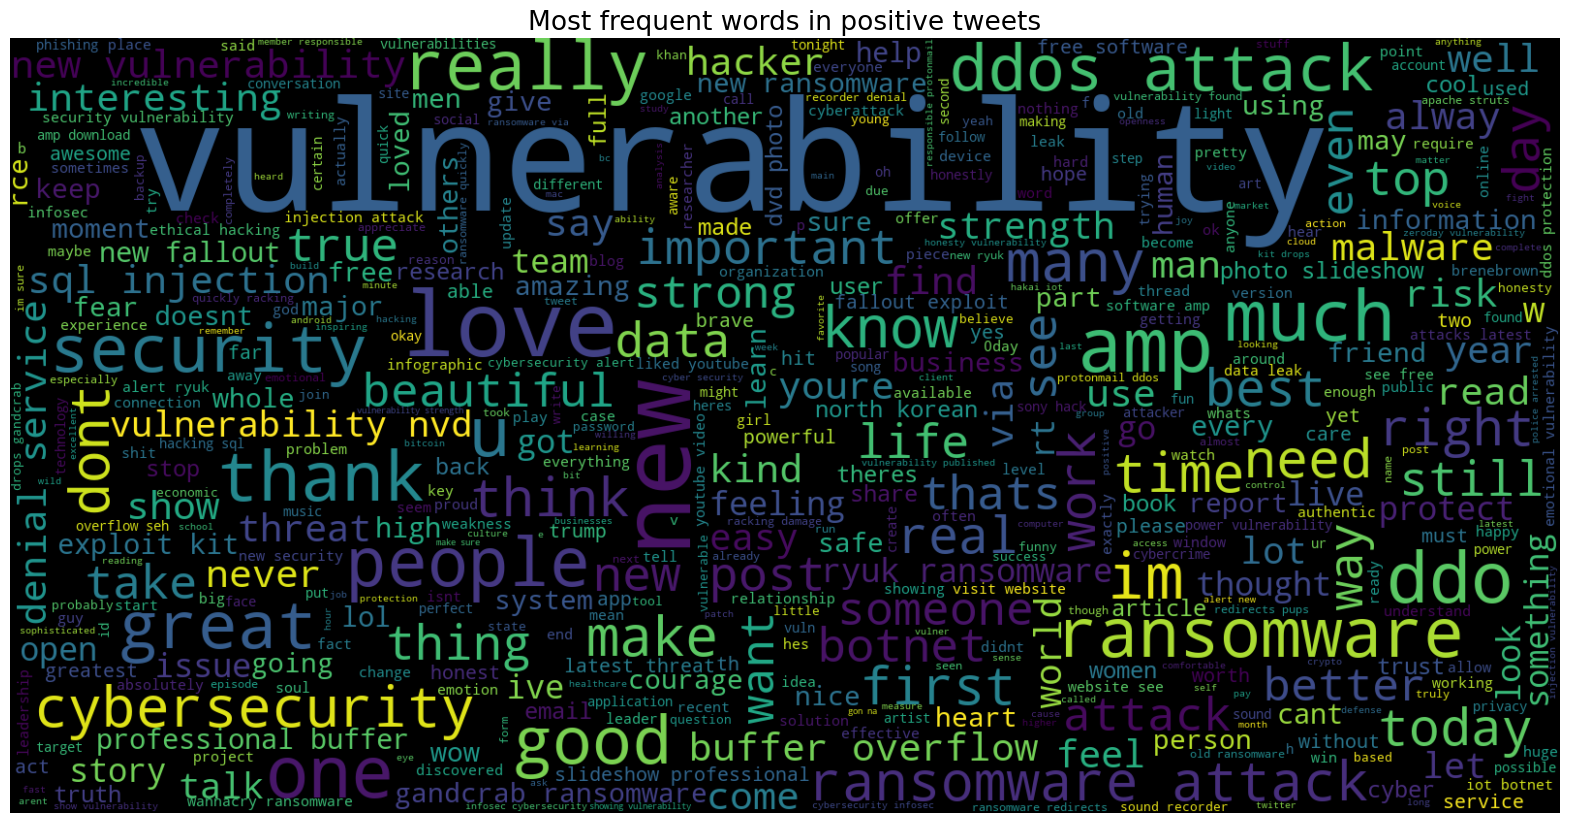

In [20]:
text = ' '.join([word for word in pos_tweets['text']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words in positive tweets', fontsize=19)
plt.show()

In [21]:
neg_tweets = text_df[text_df.sentiment == 'Negative']
neg_tweets = neg_tweets.sort_values(['polarity'], ascending= False)
neg_tweets.head()

,text,polarity,sentiment
14943,im tired letting get point vulnerability hasnt...,-9.251859e-18,Negative
12061,got something beautiful purest form vulnerabil...,-1.923077e-03,Negative
6967,strong weak vulnerable takes lot courage show ...,-2.083333e-03,Negative
21344,voter records leak texas show major risks unse...,-4.464286e-03,Negative
7458,skeds_ yeah saw banned every single major plat...,-4.464286e-03,Negative


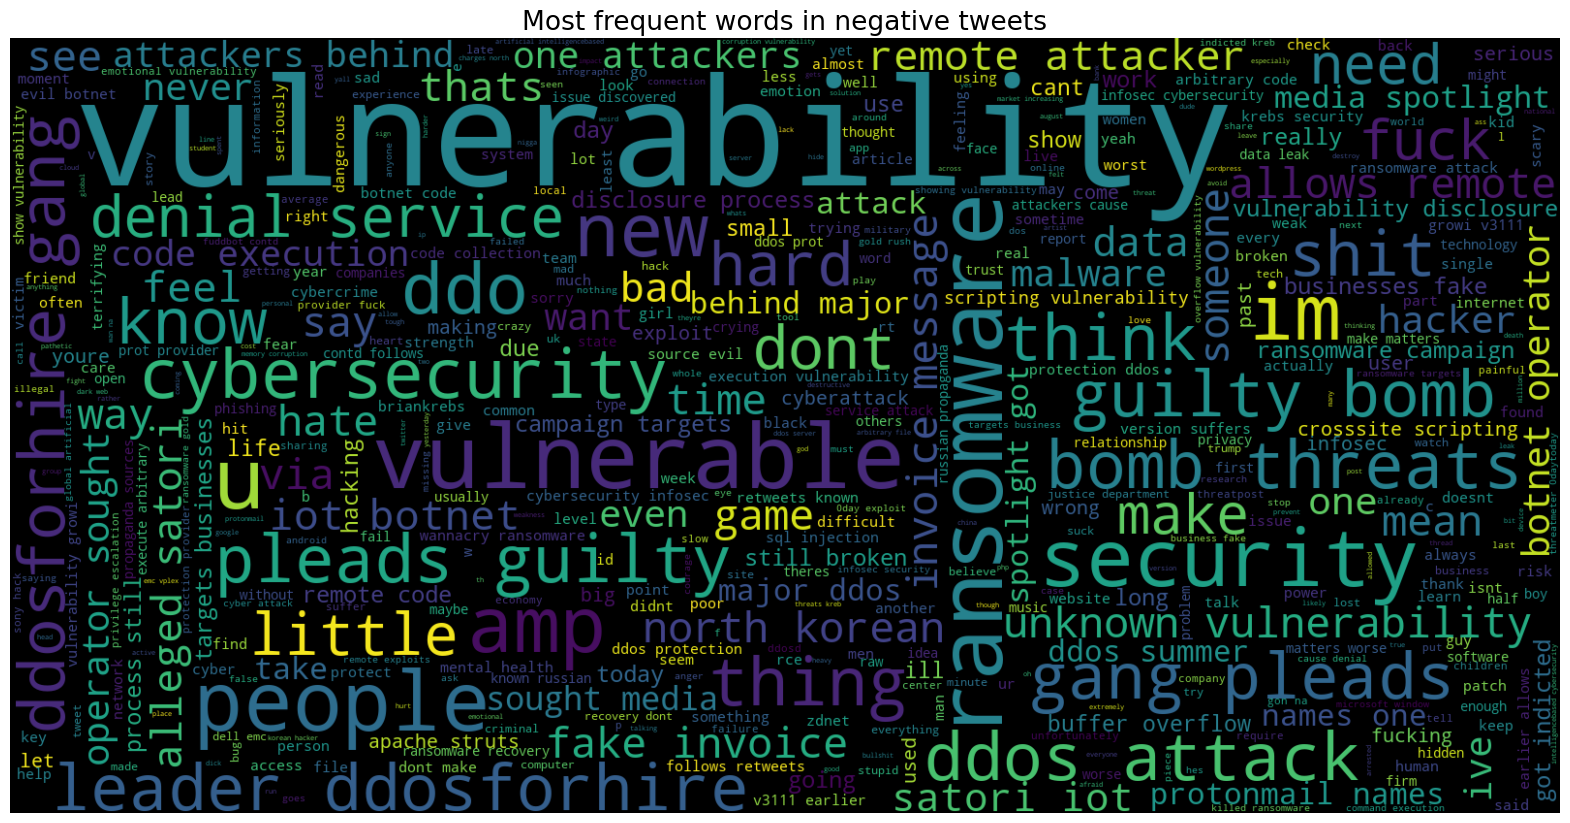

In [22]:
text = ' '.join([word for word in neg_tweets['text']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words in negative tweets', fontsize=19)
plt.show()

In [23]:
neutral_tweets = text_df[text_df.sentiment == 'Neutral']
neutral_tweets = neutral_tweets.sort_values(['polarity'], ascending= False)
neutral_tweets.head()

,text,polarity,sentiment
1,cryptocurrency scams replacing ransomware atta...,0.0,Neutral
14109,alarm kunde cb_xlabordauertest mydatasens gsm2...,0.0,Neutral
14122,alarm kunde cb_xlabordauertest mydatasens gsm2...,0.0,Neutral
14121,alarm kunde cb_xlabordauertest mydatasens gsm2...,0.0,Neutral
14120,alarm kunde cb_xlabordauertest mydatasens gsm2...,0.0,Neutral


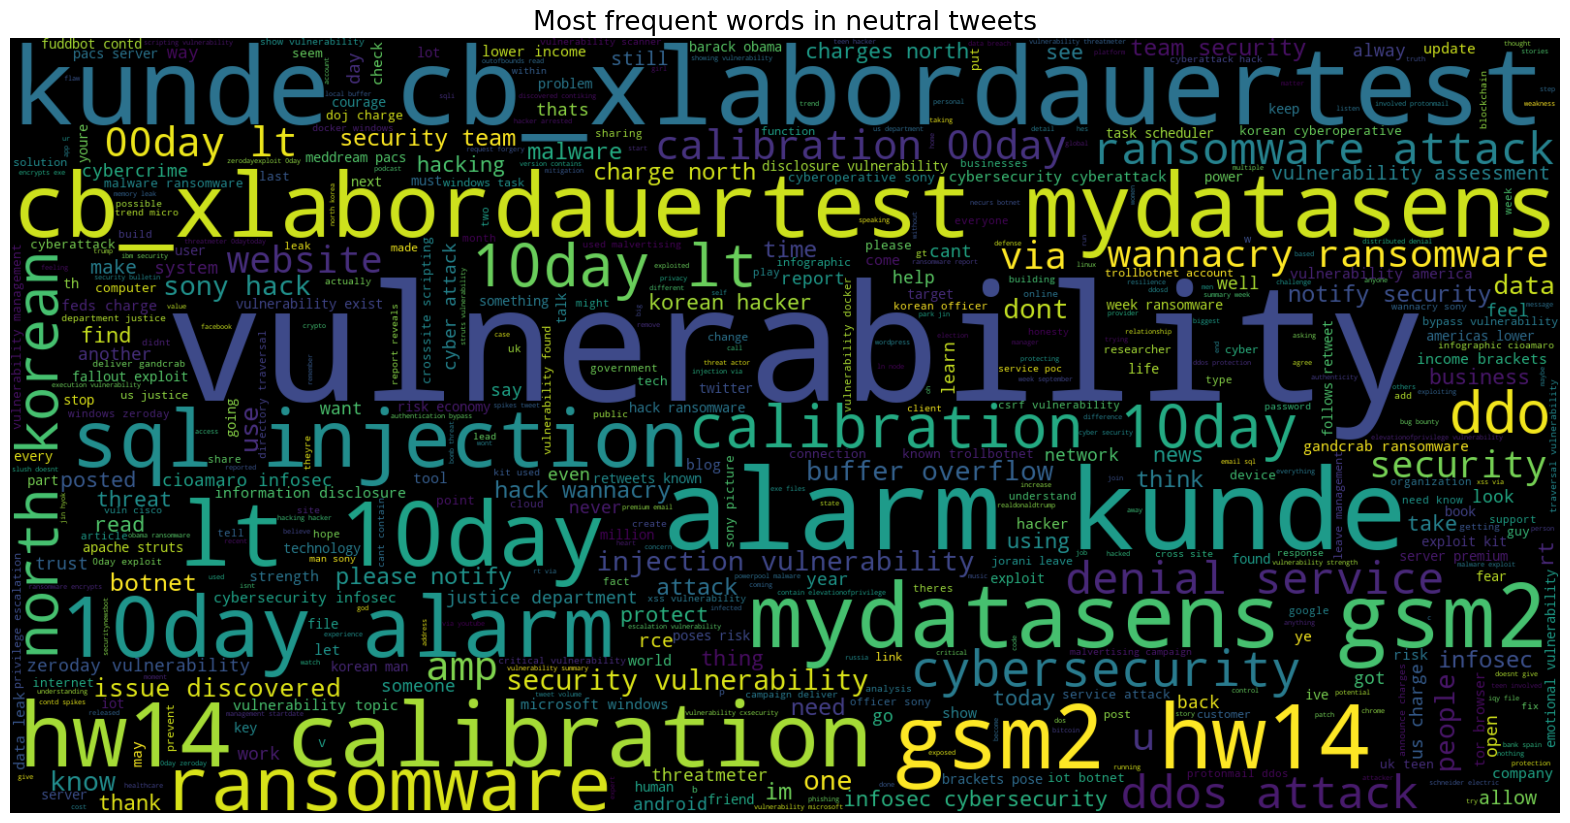

In [24]:
text = ' '.join([word for word in neutral_tweets['text']])
plt.figure(figsize=(20,15), facecolor='None')
wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most frequent words in neutral tweets', fontsize=19)
plt.show()

In [25]:
vect = CountVectorizer(ngram_range=(1,2)).fit(text_df['text'])

In [26]:
X = text_df['text']
Y = text_df['sentiment']
X = vect.transform(X)

In [27]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [28]:
print("Size of x_train:", (x_train.shape))
print("Size of y_train:", (y_train.shape))
print("Size of x_test:", (x_test.shape))
print("Size of y_test:", (y_test.shape))

Size of x_train: (12742, 114944)
Size of y_train: (12742,)
Size of x_test: (3186, 114944)
Size of y_test: (3186,)


In [29]:
import warnings
warnings.filterwarnings('ignore')

In [30]:
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
logreg_pred = logreg.predict(x_test)
logreg_acc = accuracy_score(logreg_pred, y_test)
print("Test accuracy: {:.2f}%".format(logreg_acc*100))

Test accuracy: 87.57%


In [31]:
print(confusion_matrix(y_test, logreg_pred))
print("\n")
print(classification_report(y_test, logreg_pred))

[[ 348  159   37]
 [   9 1589   18]
 [  16  157  853]]


              precision    recall  f1-score   support

    Negative       0.93      0.64      0.76       544
     Neutral       0.83      0.98      0.90      1616
    Positive       0.94      0.83      0.88      1026

    accuracy                           0.88      3186
   macro avg       0.90      0.82      0.85      3186
weighted avg       0.88      0.88      0.87      3186



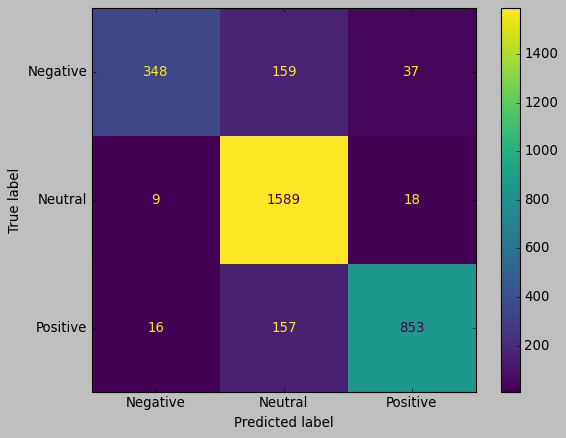

In [32]:
style.use('classic')
cm = confusion_matrix(y_test, logreg_pred, labels=logreg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=logreg.classes_)
disp.plot()

In [33]:
from sklearn.model_selection import GridSearchCV

In [34]:
param_grid={'C':[0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(), param_grid)
grid.fit(x_train, y_train)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10]})

In [35]:
print("Best parameters:", grid.best_params_)

Best parameters: {'C': 10}


In [36]:
y_pred = grid.predict(x_test)

In [38]:
logreg_acc = accuracy_score(y_pred, y_test)
print("Test accuracy: {:.2f}%".format(logreg_acc*100))

Test accuracy: 88.54%


In [39]:
print(confusion_matrix(y_test, y_pred))
print("\n")
print(classification_report(y_test, y_pred))

[[ 365  148   31]
 [   9 1587   20]
 [  19  138  869]]


              precision    recall  f1-score   support

    Negative       0.93      0.67      0.78       544
     Neutral       0.85      0.98      0.91      1616
    Positive       0.94      0.85      0.89      1026

    accuracy                           0.89      3186
   macro avg       0.91      0.83      0.86      3186
weighted avg       0.89      0.89      0.88      3186



In [41]:
from sklearn.svm import LinearSVC

In [42]:
SVCmodel = LinearSVC()
SVCmodel.fit(x_train, y_train)

LinearSVC()

In [43]:
svc_pred = SVCmodel.predict(x_test)
svc_acc = accuracy_score(svc_pred, y_test)
print("test accuracy: {:.2f}%".format(svc_acc*100))

test accuracy: 89.74%


In [44]:
print(confusion_matrix(y_test, svc_pred))
print("\n")
print(classification_report(y_test, svc_pred))

[[ 389  126   29]
 [  11 1587   18]
 [  19  124  883]]


              precision    recall  f1-score   support

    Negative       0.93      0.72      0.81       544
     Neutral       0.86      0.98      0.92      1616
    Positive       0.95      0.86      0.90      1026

    accuracy                           0.90      3186
   macro avg       0.91      0.85      0.88      3186
weighted avg       0.90      0.90      0.89      3186



In [45]:
grid = {
    'C':[0.01, 0.1, 1, 10],
    'kernel':["linear","poly","rbf","sigmoid"],
    'degree':[1,3,5,7],
    'gamma':[0.01,1]
}
grid = GridSearchCV(SVCmodel, param_grid)
grid.fit(x_train, y_train)

GridSearchCV(estimator=LinearSVC(), param_grid={'C': [0.001, 0.01, 0.1, 1, 10]})

In [46]:
print("Best parameter:", grid.best_params_)

Best parameter: {'C': 10}


In [47]:
y_pred = grid.predict(x_test)

In [48]:
logreg_acc = accuracy_score(y_pred, y_test)
print("Test accuracy: {:.2f}%".format(logreg_acc*100))

Test accuracy: 89.67%


In [49]:
print(confusion_matrix(y_test, y_pred))
print("\n")
print(classification_report(y_test, y_pred))

[[ 387  129   28]
 [  10 1589   17]
 [  18  127  881]]


              precision    recall  f1-score   support

    Negative       0.93      0.71      0.81       544
     Neutral       0.86      0.98      0.92      1616
    Positive       0.95      0.86      0.90      1026

    accuracy                           0.90      3186
   macro avg       0.92      0.85      0.88      3186
weighted avg       0.90      0.90      0.89      3186



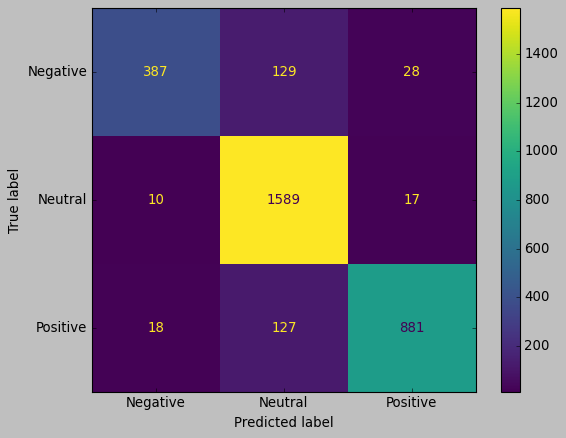

In [52]:
style.use('classic')
cm = confusion_matrix(y_test, y_pred, labels=logreg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=logreg.classes_)
disp.plot()